In this file I am deploying the model for the final user in a telegram-bot interpretation. 
I am getting the 5 min ETH data from the last day from coingecko.
So the process ollks like this: 
1) User opens our telegram chat.
2) Makes a request with a button "I want to trade"
3) Program uses api to extract the value for model to make prediction.
4) Save them in a prediction column of dataset.
5) Send the dataset with model signals to the user through the telegram chat.
6) User decides what is the current trend in model predictions.
7) Makes their own trade based on that.


In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import os

In [2]:
# CoinGecko API endpoint for ETH market chart data

# We use this specific endpoint because it provides the data from the last 24 hours without indicating the period.
# Just continuously for the last 24 hours from the moment of the request.

url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=1"


headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": os.getenv("COINGECKO_API_KEY")
}

response = requests.get(url, headers=headers)

# Check response
if response.status_code == 200:
    data = response.json()

    # Convert timestamps and create DataFrame
    def convert_to_df(key):
        df = pd.DataFrame(data[key], columns=["timestamp", key])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        return df.set_index("timestamp")

    prices_df = convert_to_df("prices")
    market_caps_df = convert_to_df("market_caps")
    volumes_df = convert_to_df("total_volumes")

    full_df = prices_df.join([market_caps_df, volumes_df])
    full_df.columns = ["price_usd", "market_cap_usd", "volume_usd"]


    print(full_df.head())

else:
    print(f"❌ Failed to fetch data. Status code: {response.status_code}")
    print(response.text)


                           price_usd  market_cap_usd    volume_usd
timestamp                                                         
2025-04-17 17:51:17.419  1611.090255    1.944555e+11  1.210398e+10
2025-04-17 17:56:08.186  1612.708066    1.944555e+11  1.041897e+10
2025-04-17 18:00:54.777  1611.523371    1.946703e+11  1.077589e+10
2025-04-17 18:06:48.998  1610.934898    1.944015e+11  1.140299e+10
2025-04-17 18:11:01.304  1613.230722    1.944015e+11  1.101164e+10


In [3]:
len(full_df)

284

In [4]:
full_df.tail()

,price_usd,market_cap_usd,volume_usd
timestamp,,,
2025-04-18 12:35:30.340,1592.763778,1.921078e+11,9.276832e+09
2025-04-18 12:40:40.070,1595.239762,1.922875e+11,6.368233e+09
2025-04-18 12:45:24.033,1595.231133,1.925308e+11,7.328880e+09
2025-04-18 12:50:18.349,1594.185145,1.924796e+11,8.957686e+09
2025-04-18 12:52:41.000,1594.076131,1.924796e+11,8.965299e+09


Since we can't receive the same data we worked previously with,
1) Now we can only get 5-min data
2) We only have the 'price_usd' column instead of 'Open', 'Close' ...

So, we will need to retrain our models with different feature matrices.

In [4]:
train_df = pd.read_csv("../main_data\Final_Data_ETH.csv",
                        parse_dates=["Open time"], index_col="Open time")

In [6]:
train_df.columns

Index(['Close', 'EMA_8', 'EMA_21', 'Prise_Direction', 'SMA_50', 'SMA_200',
       'RSI_10', 'RSI_14', 'RSI_30', 'ROC_10', 'ROC_14', 'Momentum_14',
       'Stoch_%K_14', 'Stoch_%D_14', 'Stoch_%K_200', 'Stoch_%D_200',
       'Target_Signal'],
      dtype='object')

In [7]:
train_df = train_df.drop(['Prise_Direction', 'Stoch_%K_14', 'Stoch_%D_14', 'Stoch_%K_200', 'Stoch_%D_200'], axis=1)

In [8]:
X = train_df.drop(['Target_Signal'], axis=1)
y = train_df['Target_Signal']

In [9]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [10]:
# Create models with parameters we found in 'Building_ML_Models.ipynb'
model_lgbm = LGBMClassifier(lambda_l1=1, lambda_l2=0, max_depth=10, min_data_in_leaf=300,
               n_estimators=150, random_state=42, reg_alpha=0.1)
model_hgb = HistGradientBoostingClassifier(l2_regularization=1.0, max_depth=10,
                               max_iter=150, random_state=42)

In [11]:
model_hgb.fit(X, y)

HistGradientBoostingClassifier(l2_regularization=1.0, max_depth=10,
                               max_iter=150, random_state=42)

In [12]:
model_lgbm.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 103586, number of negative: 105200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Num

LGBMClassifier(lambda_l1=1, lambda_l2=0, max_depth=10, min_data_in_leaf=300,
               n_estimators=150, random_state=42, reg_alpha=0.1)

In [13]:
from skops.io import dump

In [14]:
# Save the models
dump(model_hgb, '../final_model_hgb.skops')

dump(model_lgbm, '../final_model_lgbm.skops')

In [15]:
def add_technical_indicators(full_df):
    """
    Adds the following technical indicators to a CoinGecko DataFrame:
    - EMA (8, 21)
    - Price Direction
    - SMA (50, 200)
    - RSI (10, 14, 30)
    - ROC (10, 14)
    - Momentum (14)
    
    """
    # Exponential Moving Averages
    for period in [8, 21]:
        full_df[f'EMA_{period}'] = full_df['price_usd'].ewm(span=period, adjust=False).mean()

    # Simple Moving Averages
    for period in [50, 200]:
        full_df[f'SMA_{period}'] = full_df['price_usd'].rolling(window=period, min_periods=1).mean()

    # Relative Strength Index (RSI)
    def calculate_rsi(full_df, period=14):
        delta = full_df['price_usd'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(span=period, adjust=False, min_periods=1).mean()
        avg_loss = loss.ewm(span=period, adjust=False, min_periods=1).mean()

        rs = avg_gain / (avg_loss + 1e-10)  
        return 100 - (100 / (1 + rs))

    for period in [10, 14, 30]:
        full_df[f'RSI_{period}'] = calculate_rsi(full_df, period)

    # Rate of Change (ROC)
    for period in [10, 14]:
        full_df[f'ROC_{period}'] = full_df['price_usd'].pct_change(periods=period) * 100

    # Momentum
    full_df['Momentum_14'] = full_df['price_usd'].diff(14)

    # We can not add Stochastic %K and %D without High and Low prices
    # But CoinGecko API does not provide them in the response


    return full_df


# Add technical indicators to the DataFrame
df_full = add_technical_indicators(full_df)

Handling remaining inequalities in the resulting dataset.

In [16]:
df_full.dropna(inplace=True)

In [17]:
df_full = df_full.drop(['market_cap_usd', 'volume_usd'], axis=1)

In [18]:
df_full=df_full.rename(columns={'price_usd': 'Close'})

In [19]:
df_full.tail(14)

,Close,EMA_8,EMA_21,SMA_50,SMA_200,RSI_10,RSI_14,RSI_30,ROC_10,ROC_14,Momentum_14
timestamp,,,,,,,,,,,
2025-04-18 11:46:32.599,1588.311590,1586.864855,1586.573669,1586.564001,1584.665485,73.644167,67.957041,59.734140,0.203654,0.064321,1.020960
2025-04-18 11:52:10.296,1588.870483,1587.310550,1586.782471,1586.688791,1584.564106,77.428982,71.374800,61.924706,0.276633,0.189188,3.000270
2025-04-18 11:56:26.645,1589.766860,1587.856396,1587.053779,1586.825801,1584.474611,82.387048,76.093612,65.173039,0.380324,0.277330,4.396714
2025-04-18 12:06:20.805,1590.291784,1588.397594,1587.348143,1586.966294,1584.397875,84.779989,78.489607,66.938697,0.401194,0.327222,5.186816
2025-04-18 12:11:42.464,1589.694435,1588.685781,1587.561442,1587.088710,1584.329805,71.305707,69.361703,63.050278,0.208004,0.290895,4.610931
2025-04-18 12:15:28.556,1589.303470,1588.823045,1587.719808,1587.200150,1584.268905,63.262667,63.761833,60.587894,0.132502,0.303960,4.816209
2025-04-18 12:21:47.361,1589.585245,1588.992423,1587.889393,1587.308935,1584.220054,66.582976,66.041736,61.739098,0.206321,0.368856,5.841739
2025-04-18 12:26:24.894,1590.075701,1589.233151,1588.088149,1587.419725,1584.212089,71.972001,69.851208,63.711314,0.253626,0.387552,6.138575
2025-04-18 12:31:22.583,1590.320693,1589.474827,1588.291107,1587.513214,1584.232904,74.484199,71.682170,64.683377,0.229750,0.247481,3.926018


After these final manipulations, our Coingecko dataset's feature matrix matches the exact columns the models were trained on.   
We will predict the last 60 min, so 14 columns of 5-minute data. 

In [20]:
to_predict = df_full.tail(14)
to_predict

,Close,EMA_8,EMA_21,SMA_50,SMA_200,RSI_10,RSI_14,RSI_30,ROC_10,ROC_14,Momentum_14
timestamp,,,,,,,,,,,
2025-04-18 11:46:32.599,1588.311590,1586.864855,1586.573669,1586.564001,1584.665485,73.644167,67.957041,59.734140,0.203654,0.064321,1.020960
2025-04-18 11:52:10.296,1588.870483,1587.310550,1586.782471,1586.688791,1584.564106,77.428982,71.374800,61.924706,0.276633,0.189188,3.000270
2025-04-18 11:56:26.645,1589.766860,1587.856396,1587.053779,1586.825801,1584.474611,82.387048,76.093612,65.173039,0.380324,0.277330,4.396714
2025-04-18 12:06:20.805,1590.291784,1588.397594,1587.348143,1586.966294,1584.397875,84.779989,78.489607,66.938697,0.401194,0.327222,5.186816
2025-04-18 12:11:42.464,1589.694435,1588.685781,1587.561442,1587.088710,1584.329805,71.305707,69.361703,63.050278,0.208004,0.290895,4.610931
2025-04-18 12:15:28.556,1589.303470,1588.823045,1587.719808,1587.200150,1584.268905,63.262667,63.761833,60.587894,0.132502,0.303960,4.816209
2025-04-18 12:21:47.361,1589.585245,1588.992423,1587.889393,1587.308935,1584.220054,66.582976,66.041736,61.739098,0.206321,0.368856,5.841739
2025-04-18 12:26:24.894,1590.075701,1589.233151,1588.088149,1587.419725,1584.212089,71.972001,69.851208,63.711314,0.253626,0.387552,6.138575
2025-04-18 12:31:22.583,1590.320693,1589.474827,1588.291107,1587.513214,1584.232904,74.484199,71.682170,64.683377,0.229750,0.247481,3.926018


In [21]:
hgb_pred = model_hgb.predict(to_predict)
lgbm_pred = model_lgbm.predict(to_predict)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


In [22]:
to_predict['HGB_Pred'] = hgb_pred
to_predict['LGBM_Pred'] = lgbm_pred
to_predict

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15772\3049007825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict['HGB_Pred'] = hgb_pred
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15772\3049007825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict['LGBM_Pred'] = lgbm_pred


,Close,EMA_8,EMA_21,SMA_50,SMA_200,RSI_10,RSI_14,RSI_30,ROC_10,ROC_14,Momentum_14,HGB_Pred,LGBM_Pred
timestamp,,,,,,,,,,,,,
2025-04-18 11:46:32.599,1588.311590,1586.864855,1586.573669,1586.564001,1584.665485,73.644167,67.957041,59.734140,0.203654,0.064321,1.020960,1.0,1.0
2025-04-18 11:52:10.296,1588.870483,1587.310550,1586.782471,1586.688791,1584.564106,77.428982,71.374800,61.924706,0.276633,0.189188,3.000270,1.0,1.0
2025-04-18 11:56:26.645,1589.766860,1587.856396,1587.053779,1586.825801,1584.474611,82.387048,76.093612,65.173039,0.380324,0.277330,4.396714,1.0,1.0
2025-04-18 12:06:20.805,1590.291784,1588.397594,1587.348143,1586.966294,1584.397875,84.779989,78.489607,66.938697,0.401194,0.327222,5.186816,1.0,1.0
2025-04-18 12:11:42.464,1589.694435,1588.685781,1587.561442,1587.088710,1584.329805,71.305707,69.361703,63.050278,0.208004,0.290895,4.610931,1.0,1.0
2025-04-18 12:15:28.556,1589.303470,1588.823045,1587.719808,1587.200150,1584.268905,63.262667,63.761833,60.587894,0.132502,0.303960,4.816209,1.0,1.0
2025-04-18 12:21:47.361,1589.585245,1588.992423,1587.889393,1587.308935,1584.220054,66.582976,66.041736,61.739098,0.206321,0.368856,5.841739,1.0,1.0
2025-04-18 12:26:24.894,1590.075701,1589.233151,1588.088149,1587.419725,1584.212089,71.972001,69.851208,63.711314,0.253626,0.387552,6.138575,1.0,1.0
2025-04-18 12:31:22.583,1590.320693,1589.474827,1588.291107,1587.513214,1584.232904,74.484199,71.682170,64.683377,0.229750,0.247481,3.926018,1.0,1.0


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

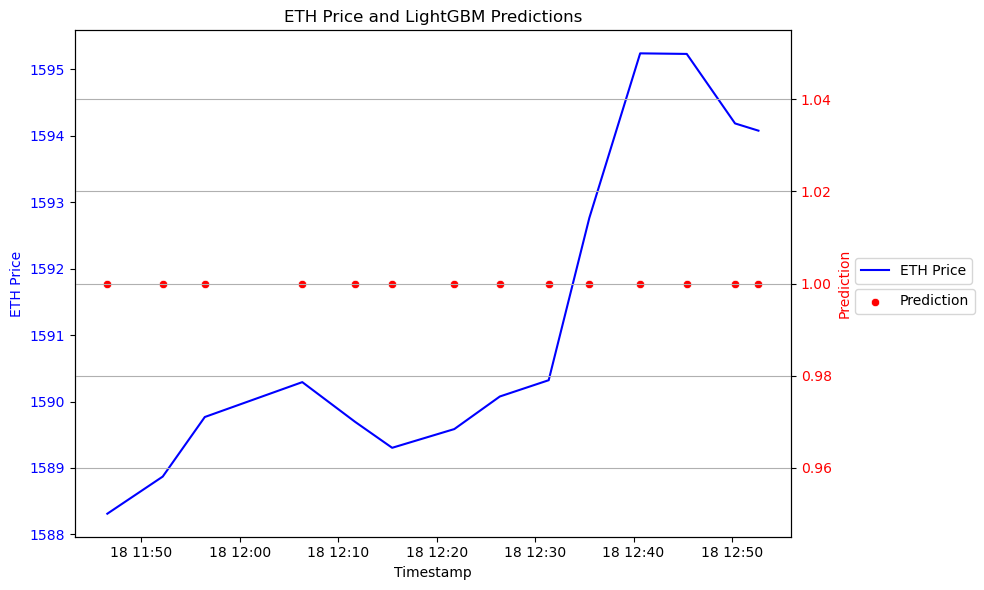

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the ETH prices on the left y-axis (ax1)
sns.lineplot(x=to_predict.index, y='Close', data=to_predict, ax=ax1, color='b', label='ETH Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('ETH Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the right y-axis (ax2) for predictions
ax2 = ax1.twinx()
sns.scatterplot(x=to_predict.index, y='LGBM_Pred', data=to_predict, ax=ax2, color='r', label='Prediction', markers='X')
ax2.set_ylabel('Prediction', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('ETH Price and LightGBM Predictions')

ax1.legend(loc=(1.09, 0.5))
ax2.legend(loc=(1.09, 0.44))
plt.grid()
plt.tight_layout()
plt.show()

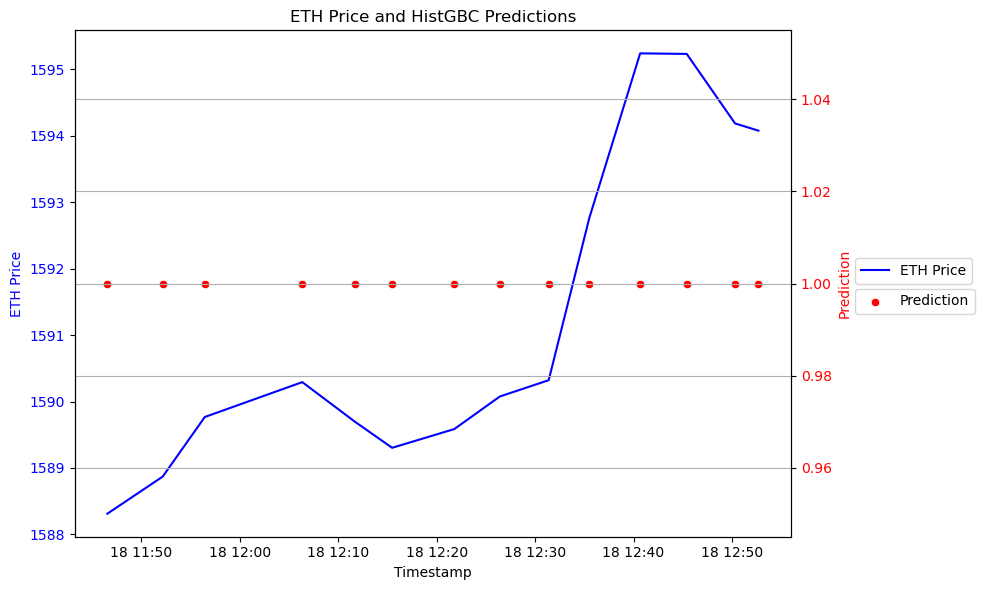

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the ETH prices on the left y-axis (ax1)
sns.lineplot(x=to_predict.index, y='Close', data=to_predict, ax=ax1, color='b', label='ETH Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('ETH Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the right y-axis (ax2) for predictions
ax2 = ax1.twinx()
sns.scatterplot(x=to_predict.index, y='HGB_Pred', data=to_predict, ax=ax2, color='r', label='Prediction', markers='X')
ax2.set_ylabel('Prediction', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('ETH Price and HistGBC Predictions')

ax1.legend(loc=(1.09, 0.5))
ax2.legend(loc=(1.09, 0.44))
plt.grid()
plt.tight_layout()
plt.show()

---------------------------------


# We are now fully-set to go to the **Final part** - 
## Telegram Bot application